# Nucleus Detection

### Open questions

* Still not sure if by training on non 256x256 data we are improving... Maybe consider just resizing everything to that
    * I think we should check whether number of nuclei (and size of) is propto image size
    * If the number is constant, then should resize.
    * If the number varies, then should do what currently doing (cut)
    * Basically, if larger images are zooms, then we should resize everything. If they are actually larger FOV then we should cut.
* Consider using all 3 colors - this would be easy - just have input of 3 channels
* the paper mentions something about how to init network weights. Could consider doing it
* Setting the weights (for calculating error) I think is pretty important. Could probably think more about that
* Do I need to do more normalization than what I am already doing?

### Mid term plans

* Data augmentation (already doing some, could do more/better)
* https://www.kaggle.com/ahassaine/pure-image-processing-lb-0-274
* test time augmentation
* consider other learners (ADAM?)
* Try bumping learning rates back up (basically think of other learning rate schedulers).

# Imports

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import data_loaders, net, imcut
import plot_helpers.plot as plot
from evaluations.iou import log_iou, iou_loss
import prepare_submission as ps
import helpers as h
import data_augmentation as da

import matplotlib.pyplot as plt
import numpy as np
import functools
import torch
from torch.autograd import Variable
from sklearn import model_selection
from scipy.ndimage.interpolation import rotate
from tqdm import tqdm

# incase things get messed up
from importlib import reload

# Data

In [5]:
train_raw, train_keys_raw = data_loaders.training_images()
summary_masks_raw, weights_raw = data_loaders.masks_and_weights("one_and_two_term_weights")

In [6]:
train_shapes = {}
for i in range(len(train_raw)):
    img = train_raw[i]
    weight = weights_raw[i]
    mask = summary_masks_raw[i]
    if img.shape[0] < 256 or img.shape[1] < 256: raise Exception("We can't handle small training images")
    try:
        train_shapes[img.shape].append((img, weight, mask))
    except:
        train_shapes[img.shape] = [(img, weight, mask)]

In [ ]:
# This takes a minute
train, weights, summary_masks = [], [], []
for shp, images in train_shapes.items():
    y_cut, x_cut = imcut.training_patchify(shp)
    for img_index in range(len(images)):
        for i in range(len(y_cut)):
            for j in range(len(x_cut)):
                region = [slice(y_cut[i], y_cut[i] + 256), slice(x_cut[j], x_cut[j] + 256)]
                train.extend(da.augment(images[img_index][0][region]))
                weights.extend(da.augment(images[img_index][1][region]))
                summary_masks.extend(da.augment(images[img_index][2][region]))

In [18]:
trainT, valid, weightsT, valid_weights, summary_masksT, valid_summary_masks = model_selection.train_test_split(train, weights, summary_masks, test_size=0.2)

trainV, validV = h.tensorfy(trainT), h.tensorfy(valid)
weightsV, valid_weightsV = h.tensorfy(weightsT), h.tensorfy(valid_weights)
summary_masksV, valid_summary_masksV = h.tensorfy(summary_masksT), h.tensorfy(valid_summary_masks)

assert summary_masksV.shape == weightsV.shape and trainV.shape == weightsV.shape
print(summary_masksV.shape, type(trainV))
del(train, weights, summary_masks)

torch.Size([8896, 1, 256, 256]) <class 'torch.FloatTensor'>


### Sanity check

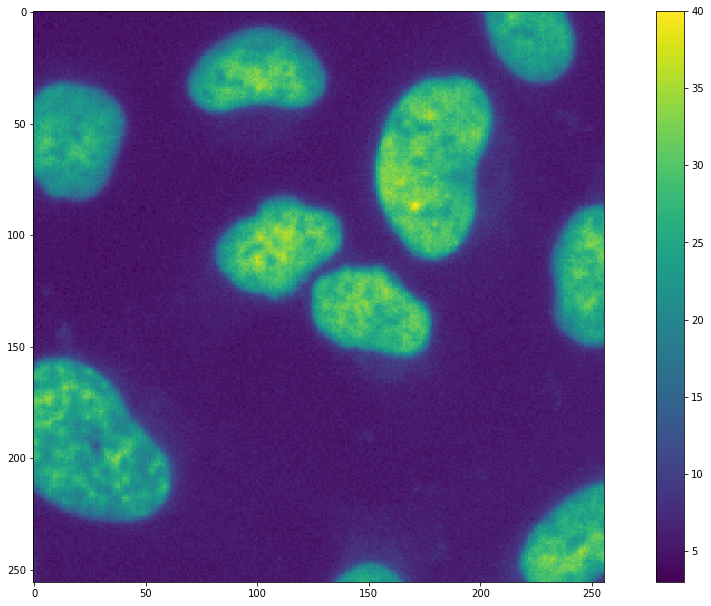

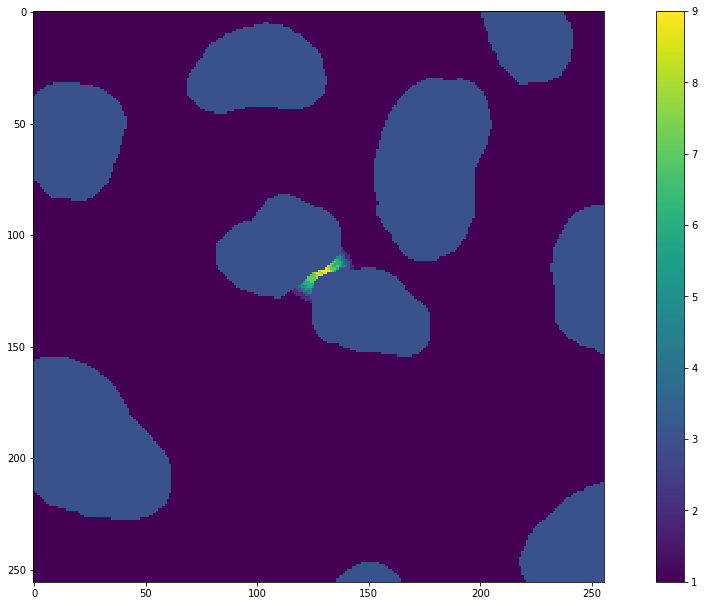

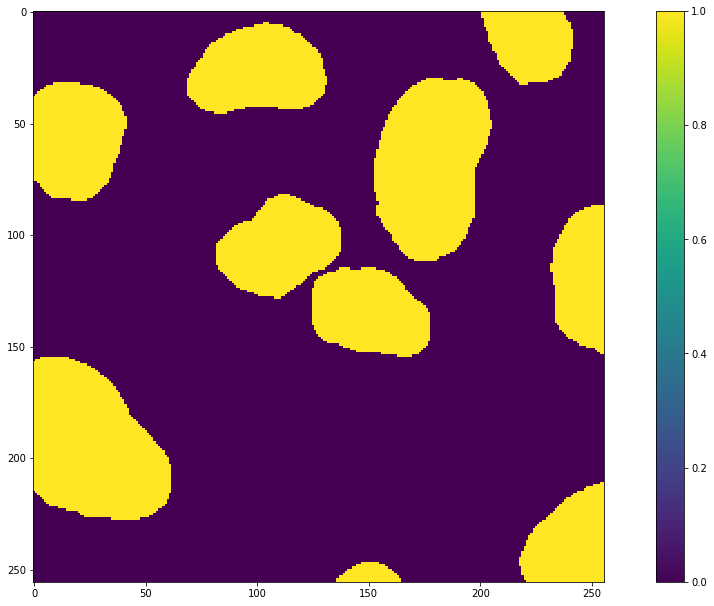

In [12]:
i = 800
plot(trainT[i])
plot(weightsT[i])
plot(summary_masksT[i])

# Exploration

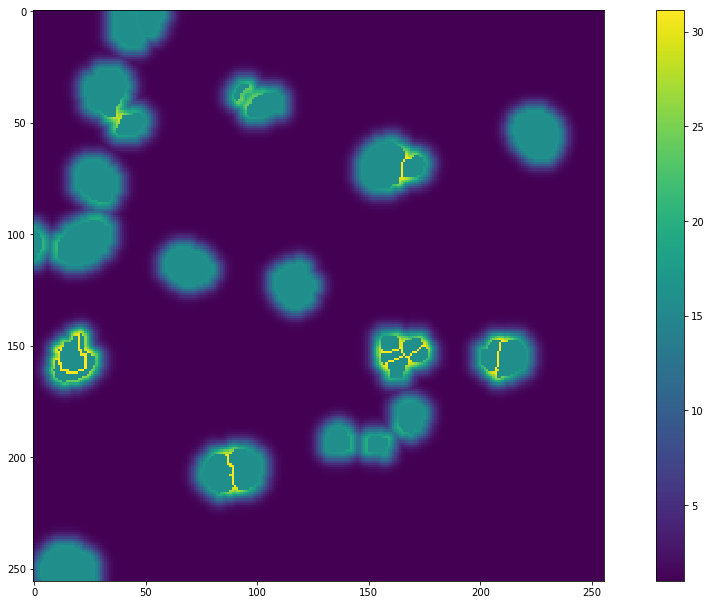

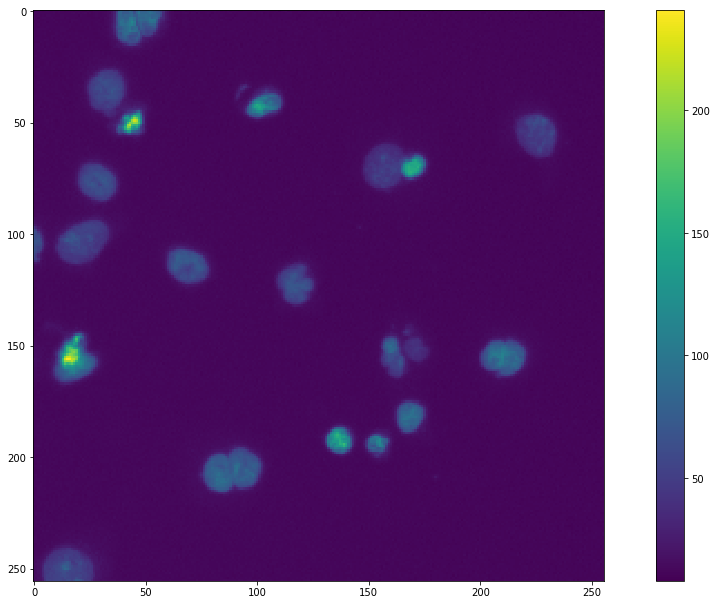

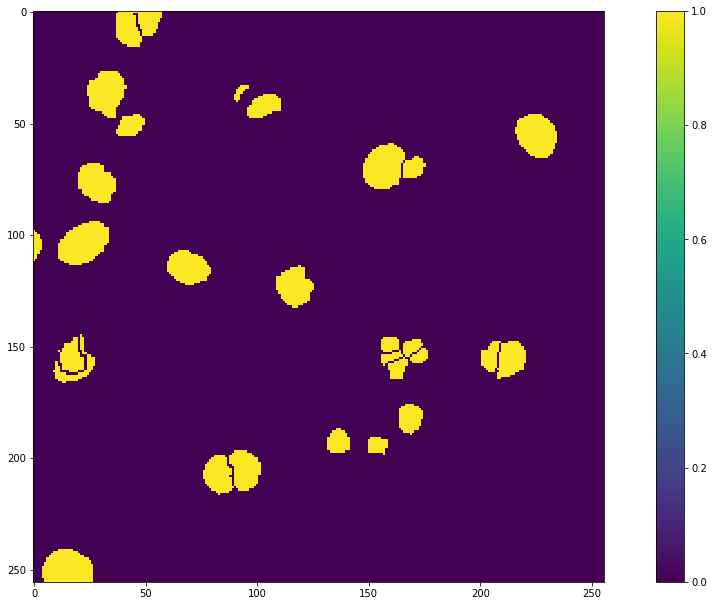

In [13]:
for i in [weights, train, summary_masks]:
    plot.imshow(i[3])


# Train

In [20]:
n = net.u_net().cuda()
# Large momentum because our batch size is small. We want many of the recent images to impact our move.
optimizer = torch.optim.SGD(n.parameters(), lr=0.001, momentum=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, cooldown=0)
batchsize = 5
epoch_size, validation_size = 500, 50
training_losses, validation_losses = [], []
epoch_num = 0

In [25]:
for epoch in range(2):
    n.train()
    epoch_num += 1
    shuffle = torch.randperm(len(trainV))[:epoch_size]
    t = tqdm(range(0, epoch_size, batchsize), desc="{} Epoch".format(epoch_num))
    training_loss = 0
    for i in t:
        indexes = shuffle[i:i+batchsize]
        # Define input data
        inp = trainV[indexes]
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()

        # Define expected data and weights
        weight = Variable(weightsV[indexes]).cuda()
        exp = Variable(summary_masksV[indexes]).cuda()

        # Ready net
        optimizer.zero_grad()

        # Run net and get output ready for loss and backgrad
        out = n(inp)[:,:,2:-2,2:-2]
        
        # Calculate loss
        t_loss = (weight * (exp - out)**2).mean()
        training_loss += t_loss.data[0]
        t_loss.backward()
        optimizer.step()
    training_loss = training_loss * batchsize / epoch_size
    training_losses.append(training_loss)
    print("Training loss", training_loss)
    
    # Validation
    n.train(False)
    validation_loss = 0
    shuffle = torch.randperm(len(validV))[:validation_size]
    for i in range(0, validation_size, batchsize):
        indexes = shuffle[i:i+batchsize]
        inp = validV[indexes]
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
        out = n(inp)[:,:,2:-2,2:-2]

        weight = valid_weightsV[indexes].cuda()
        exp = valid_summary_masksV[indexes].cuda()
        validation_loss += (weight * (exp - out.data)**2).mean()
    
    # Update LR
    validation_loss = validation_loss * batchsize / validation_size
    scheduler.step(validation_loss)
    validation_losses.append(validation_loss)
    print("Validation loss", validation_loss, flush=True)

51 Epoch: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Training loss 0.173384325876832
Validation loss 0.17450583651661872


52 Epoch: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Training loss 0.1644890721142292
Validation loss 0.3653909757733345


# Post train sanity checks

(0.1, 0.2)

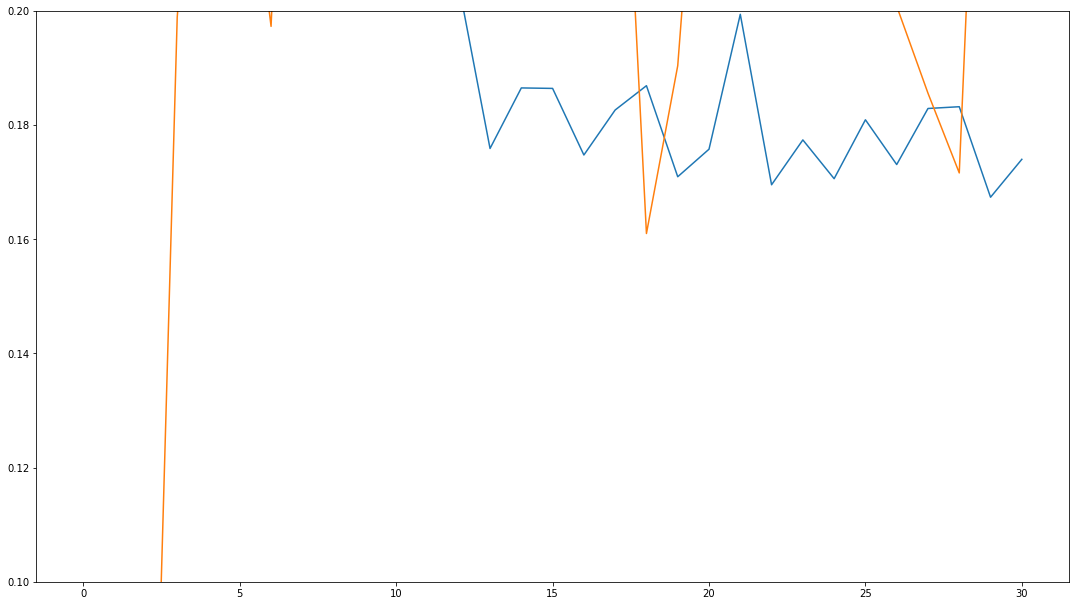

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5) 
ax.plot(training_losses)
ax.plot(validation_losses)
ax.set_ylim(0.1, 0.2)

# Validation

In [26]:
# Mostly useful to store results in array
n.train(False)
loss = 0
valid_results = []
for i in range(len(validV)): 
    inp = validV[i:i+1]
    inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
    out = n(inp)[:,:,2:-2,2:-2]
    
    valid_results.append(out.data[0][0].cpu().numpy())
    
    weight = valid_weightsV[i:i+1].cuda()
    exp = valid_summary_masksV[i:i+1].cuda()
    loss += (weight * (exp - out.data)**2).mean()
    
print(loss)

807.1257206714945


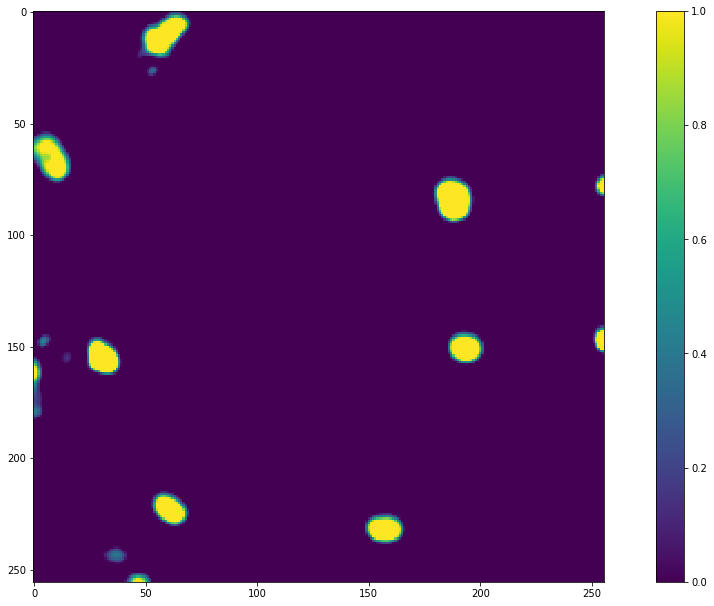

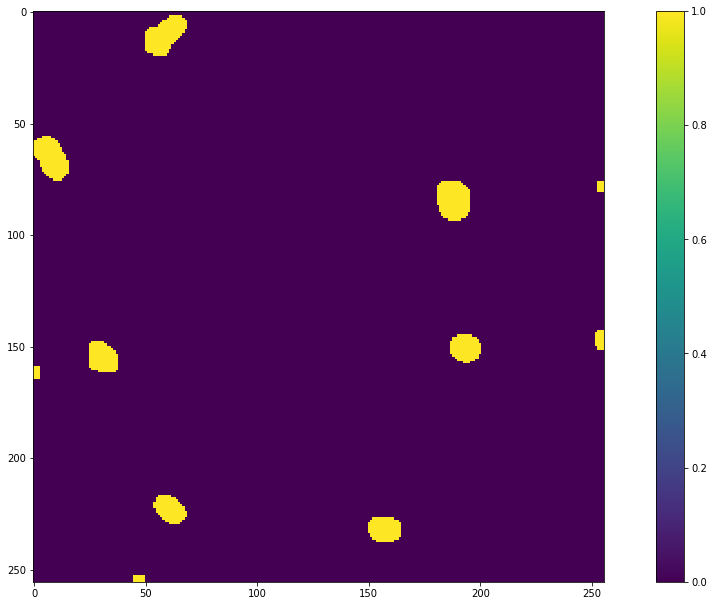

In [27]:
i = 29
plot.imshow(valid_results[i])
plot.imshow(ps.cleanup(ps.binarize(valid_results[i])))

### You probably don't need this now that you have otsu!

In [82]:
# otsu
loss = 0
for i in range(len(valid_results)):
    pred = ps.cleanup(ps.binarize(valid_results[i]))
    true = valid_summary_masksV[i][0].numpy()
    l = iou_loss(pred, true)
    loss += l
print(loss)

otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image


/home/christopher/code/ml/data-science-bowl-2018/evaluations/iou.py:60: RuntimeWarning: divide by zero encountered in true_divide
  iou = intersection / union


otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
otsu failure - needs multi colored image
157.74709592174744


0.3


/home/christopher/code/ml/data-science-bowl-2018/evaluations/iou.py:60: RuntimeWarning: divide by zero encountered in true_divide
  iou = intersection / union


0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37000000000000005
0.38000000000000006
0.39000000000000007
0.4000000000000001
0.4100000000000001
0.4200000000000001
0.4300000000000001
0.4400000000000001
0.4500000000000001
0.46000000000000013
0.47000000000000014
0.48000000000000015
0.49000000000000016
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.6000000000000003
0.6100000000000003
0.6200000000000003
0.6300000000000003
0.6400000000000003
0.6500000000000004
0.6600000000000004
0.6700000000000004
0.6800000000000004
0.6900000000000004
0.7000000000000004
0.7100000000000004
0.7200000000000004
0.7300000000000004
0.7400000000000004


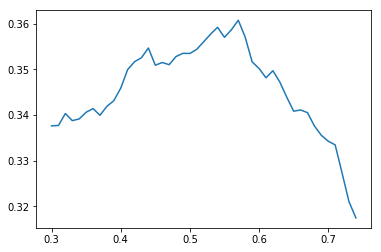

In [84]:
n.train(False)
losses = []
# consider otsu thresholding?
cutoffs = np.arange(0.30, 0.75, 0.01)
for cutoff in cutoffs:
    print(cutoff)
    loss = 0
    for i in range(len(valid_results)):
        pred = ps.cleanup(ps.binarize(valid_results[i], cutoff))
        true = valid_summary_masksV[i][0].numpy()
        l = iou_loss(pred, true)
        loss += l
    losses.append(loss / len(valid_results))
plt.plot(cutoffs, losses)

# Test

In [28]:
test_raw, test_keys_raw = data_loaders.test_images()

In [29]:
shapes = {}
keys = {}
for i in range(len(test_raw)):
    shape = test_raw[i].shape
    try:
        shapes[shape].append(test_raw[i])
        keys[shape].append(test_keys_raw[i])
    except:
        shapes[shape] = [test_raw[i]]
        keys[shape] = [test_keys_raw[i]]

In [30]:
for k, v in shapes.items():
    shapes[k] = h.tensorfy(v)

In [31]:
shapes.keys()

dict_keys([(256, 256), (520, 348), (512, 680), (512, 640), (520, 696), (519, 161), (519, 162), (260, 347), (524, 348), (519, 253), (390, 239)])

In [39]:
n.train(False)
inp_size = 348
results, results_binary, results_keys = [], [], []
for shp, images in shapes.items():
    y_cut, x_cut = imcut.patchify(shp)

    for img_index in range(len(images)):
        res = np.zeros(shp)
        res_bin = np.zeros(shp, dtype=np.uint8)
        for i in range(len(y_cut) - 1):
            for j in range(len(x_cut) - 1):
                 
                height = y_cut[i+1] - y_cut[i]
                width = x_cut[j+1] - x_cut[j]
                inp = images[img_index:img_index+1,:,y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]]
                orig_shape = inp.shape
                
                width_pad = (inp_size-width)//2
                height_pad = (inp_size-height)//2
                inp = torch.nn.ReflectionPad2d(
                    (width_pad, width_pad, height_pad, height_pad),
                )(inp).cuda()
                assert inp.shape == (1, 1, inp_size, inp_size)
                
                width_unpad = (260 - width) // 2
                height_unpad = (260 - height) // 2
                out = n(inp)[:,:,height_unpad:-height_unpad,width_unpad:-width_unpad]
                assert out.shape == orig_shape
                
                res[y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]] = out.data
                res_bin[y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]] = ps.binarize(out.data.cpu().numpy())
                
        results.append(res)
        results_binary.append(res_bin)
        results_keys.append(keys[shp][img_index])

low cutoff: 0.0016353390528820455
low cutoff: 0.173828125
low cutoff: 0.04499378381296992
low cutoff: 0.046993226860649884
low cutoff: 0.193359375
low cutoff: 0.04009086813312024
low cutoff: 0.032106530969031155
low cutoff: 0.03674259828403592
low cutoff: 0.1436514430679381
low cutoff: 0.024836092488840222
low cutoff: 0.189453125
low cutoff: 0.16588105354458094
low cutoff: 0.00551959837321192
low cutoff: 0.15384265570901334
otsu failure - needs multi colored image
low cutoff: 1.3495504390448332e-05
low cutoff: 0.1793336095288396
otsu failure - needs multi colored image


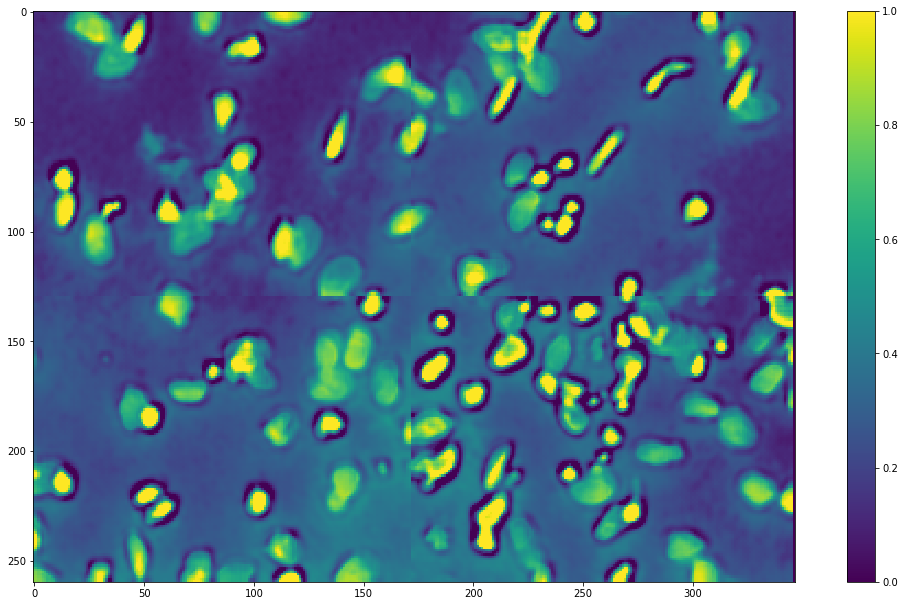

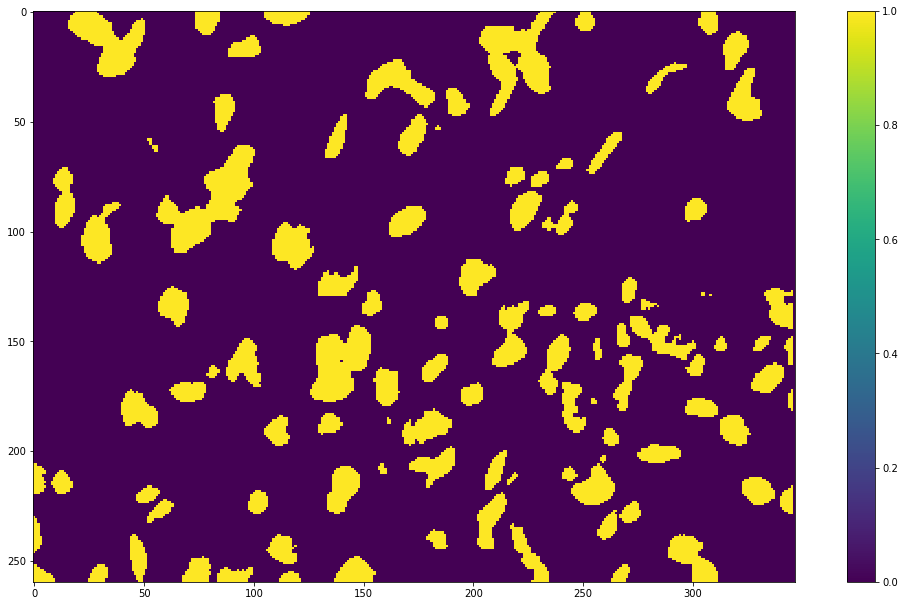

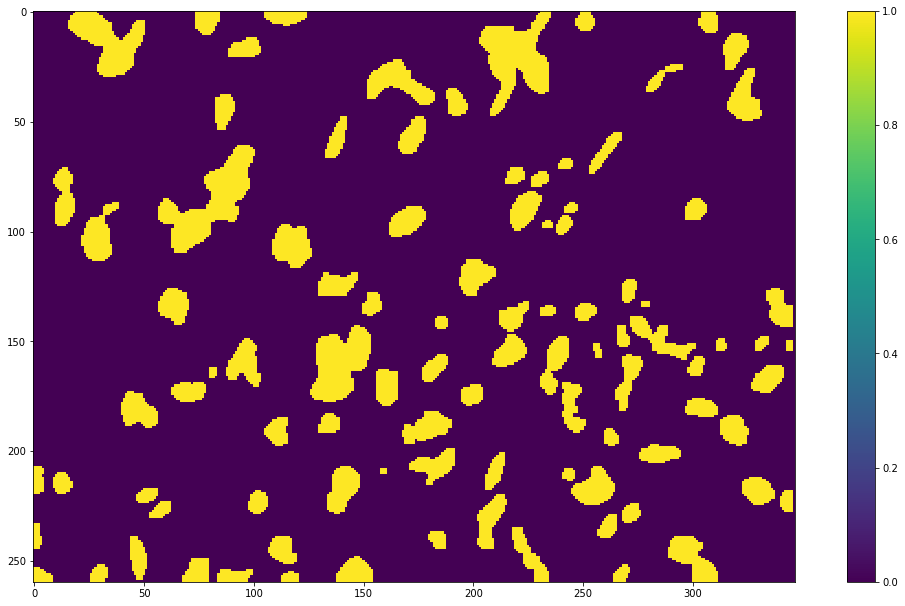

In [40]:
i = 53
plot.imshow(results[i])
plot.imshow(results_binary[i])
plot.imshow(ps.cleanup(results_binary[i]))

In [41]:
ps.write_submission("test_nn_out", [ps.cleanup(i) for i in results_binary], results_keys)

Submitting for 65 images


In [ ]:
res